In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import warnings
import wordcloud


from textblob import TextBlob


from nltk.stem.porter import PorterStemmer
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics

warnings.filterwarnings('ignore')


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.style.use('fivethirtyeight')

<img src='http://s3.birthmoviesdeath.com/images/made/rottentomatoespetition_1050_591_81_s_c1.jpg'>

# Goals
 - Explore & understand the dataset
 - Sentiment Analysis for Critic
 - Classify Fresh or Rotten

# Dataset

Rotten Tomatoes gathers movie reviews from critics. An entry on the website typically consists of a short quote, a link to the full review, and a Fresh/Rotten classification which summarizes whether the critic liked or disliked the movie.

<img src='Rt-example.png'>

In [53]:
rt = pd.read_csv('rotten_tomatoes.csv')

In [54]:
rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27631 entries, 0 to 27630
Data columns (total 8 columns):
critic         23740 non-null object
fresh          27631 non-null object
imdb           27631 non-null int64
publication    27631 non-null object
quote          15561 non-null object
review_date    27631 non-null object
rtid           27631 non-null int64
title          27631 non-null object
dtypes: int64(2), object(6)
memory usage: 1.7+ MB


In [55]:
rt.tail()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
27626,Elvis Mitchell,none,218112,New York Times,NaN,2000-01-01,770736756,The Closer You Get
27627,Roger Ebert,rotten,218112,Chicago Sun-Times,NaN,2000-01-01,770736756,The Closer You Get
27628,Amy Taubin,none,218112,Village Voice,NaN,2000-01-01,770736756,The Closer You Get
27629,Peter Stack,none,218112,San Francisco Chronicle,NaN,2000-01-01,770736756,The Closer You Get
27630,James Berardinelli,fresh,218112,ReelViews,NaN,2000-01-01,770736756,The Closer You Get


# Clean data

In [56]:
rt = rt[rt.quote.notnull()]

In [57]:
rt.fresh.value_counts()

fresh     9482
rotten    6052
none        27
Name: fresh, dtype: int64

In [58]:
rt = rt[rt.fresh != 'none']

In [59]:
rt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15534 entries, 1 to 27616
Data columns (total 8 columns):
critic         14770 non-null object
fresh          15534 non-null object
imdb           15534 non-null int64
publication    15534 non-null object
quote          15534 non-null object
review_date    15534 non-null object
rtid           15534 non-null int64
title          15534 non-null object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


In [60]:
rt.fresh.value_counts()

fresh     9482
rotten    6052
Name: fresh, dtype: int64

In [61]:
9482 / (6052+9482)

0.6104029869962663

In [62]:
rt.tail()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
27606,Ronald Holloway,fresh,86005,Variety,Measures up to the promise Ballard amply provi...,2008-07-23,12606,Never Cry Wolf
27607,NaN,fresh,86005,Time Out,"For the most part very absorbing, the film suf...",2006-01-26,12606,Never Cry Wolf
27608,Vincent Canby,fresh,86005,New York Times,Perhaps the best thing about the film is that ...,2004-08-30,12606,Never Cry Wolf
27609,Dave Kehr,fresh,86005,Chicago Reader,The film is still memorable for its compassion...,2000-01-01,12606,Never Cry Wolf
27616,Don Druker,fresh,55353,Chicago Reader,It does have enough gritty insights and (for t...,2007-11-13,18541,A Raisin in the Sun


# Explore

In [63]:
print ("Number of reviews: ", rt.quote.size)
print ("Number of critics: ", rt.critic.unique().size)
print ("Number of movies: ", rt.title.unique().size)

Number of reviews:  15534
Number of critics:  622
Number of movies:  1921


#### Average "freshness" of critics with minimum 100 reviews

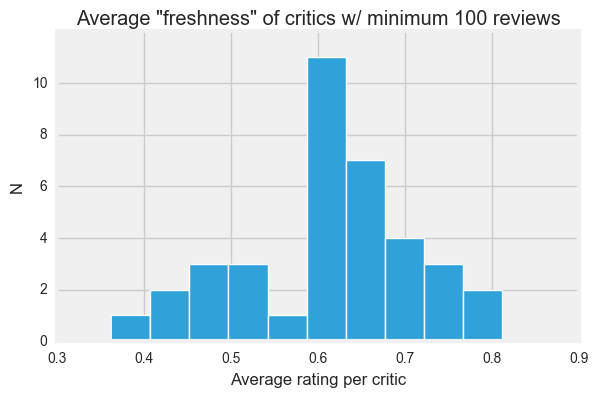

In [64]:
df = rt.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average rating per critic")
plt.ylabel("N")
plt.title('Average "freshness" of critics w/ minimum 100 reviews')
plt.yticks([0, 2, 4, 6, 8, 10]);

#### Top 5 critics by counts

In [97]:
rt.critic.value_counts()[:5]

Roger Ebert           1132
James Berardinelli     804
Janet Maslin           515
Variety Staff          429
Jonathan Rosenbaum     412
Name: critic, dtype: int64

---

# Preprocess data

In [66]:
def clean_reviews(l):
    """
    INPUT: reviews
    OUTPUT: list of cleaned reviews
    """
    
    l = list(l)
    ps = PorterStemmer()
    punc = list
    
    for i, review in enumerate(l):
        # lowercase the review
        review = review.lower()
        
        # replace punctuation newline characters
        review = re.sub(r"[,.;@#?!&$']+", ' ', review)
        
        # stem & rejoin words of the review
        stemmed_review = u""
        
        for w, word in enumerate(review.split()):
            try:
                stemmed_review += ps.stem_word(word) + " "
            # if we can't stem the word, just skip stemming it
            except:
                stemmed_review += word + " "

        # now override the review
        l[i] = stemmed_review
    
    return l

In [67]:
rt['clean_quote'] = clean_reviews(rt.quote)

In [68]:
rt.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title,clean_quote
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story,so ingeni in concept design and execut that yo...
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story,the year s most invent comedi
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story,a win anim featur that ha someth for everyon o...
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story,the film sport a provoc and appeal stori that ...
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story,an entertain computer-gener hyperrealist anim ...


---

# Roger Ebert Sentiment Analysis

#### Create a DataFrame of just Roger Ebert reviews

In [69]:
ebert = rt[rt.critic == 'Roger Ebert']
ebert.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title,clean_quote
11,Roger Ebert,fresh,114709,Chicago Sun-Times,The result is a visionary roller-coaster ride ...,2000-01-01,9559,Toy story,the result is a visionari roller-coast ride of...
30,Roger Ebert,rotten,113497,Chicago Sun-Times,A gloomy special-effects extravaganza filled w...,2000-01-01,12436,Jumanji,a gloomi special-effect extravaganza fill with...
40,Roger Ebert,rotten,107050,Chicago Sun-Times,The movie is too pat and practiced to really b...,2000-01-01,10498,Grumpy Old Men,the movi is too pat and practic to realli be c...
56,Roger Ebert,fresh,114885,Chicago Sun-Times,An escapist fantasy that women in the audience...,2000-01-01,16697,Waiting to Exhale,an escapist fantasi that women in the audienc ...
80,Roger Ebert,fresh,113277,Chicago Sun-Times,Michael Mann's writing and direction elevate t...,2000-01-01,13098,Heat,michael mann s write and direct elev thi mater...


#### Join all of Roger Ebert's reviews into one string

In [76]:
ebert_reviews = ' '.join(ebert.quote)

#### Basic sentiment analysis using TextBlob

In [77]:
ebert_blob = TextBlob(ebert_reviews)

In [78]:
ebert_blob.sentiment.polarity

0.1660656479388838

In [79]:
ebert.fresh.value_counts()

fresh     762
rotten    370
Name: fresh, dtype: int64

In [80]:
means['Roger Ebert']

0.67314487632508835

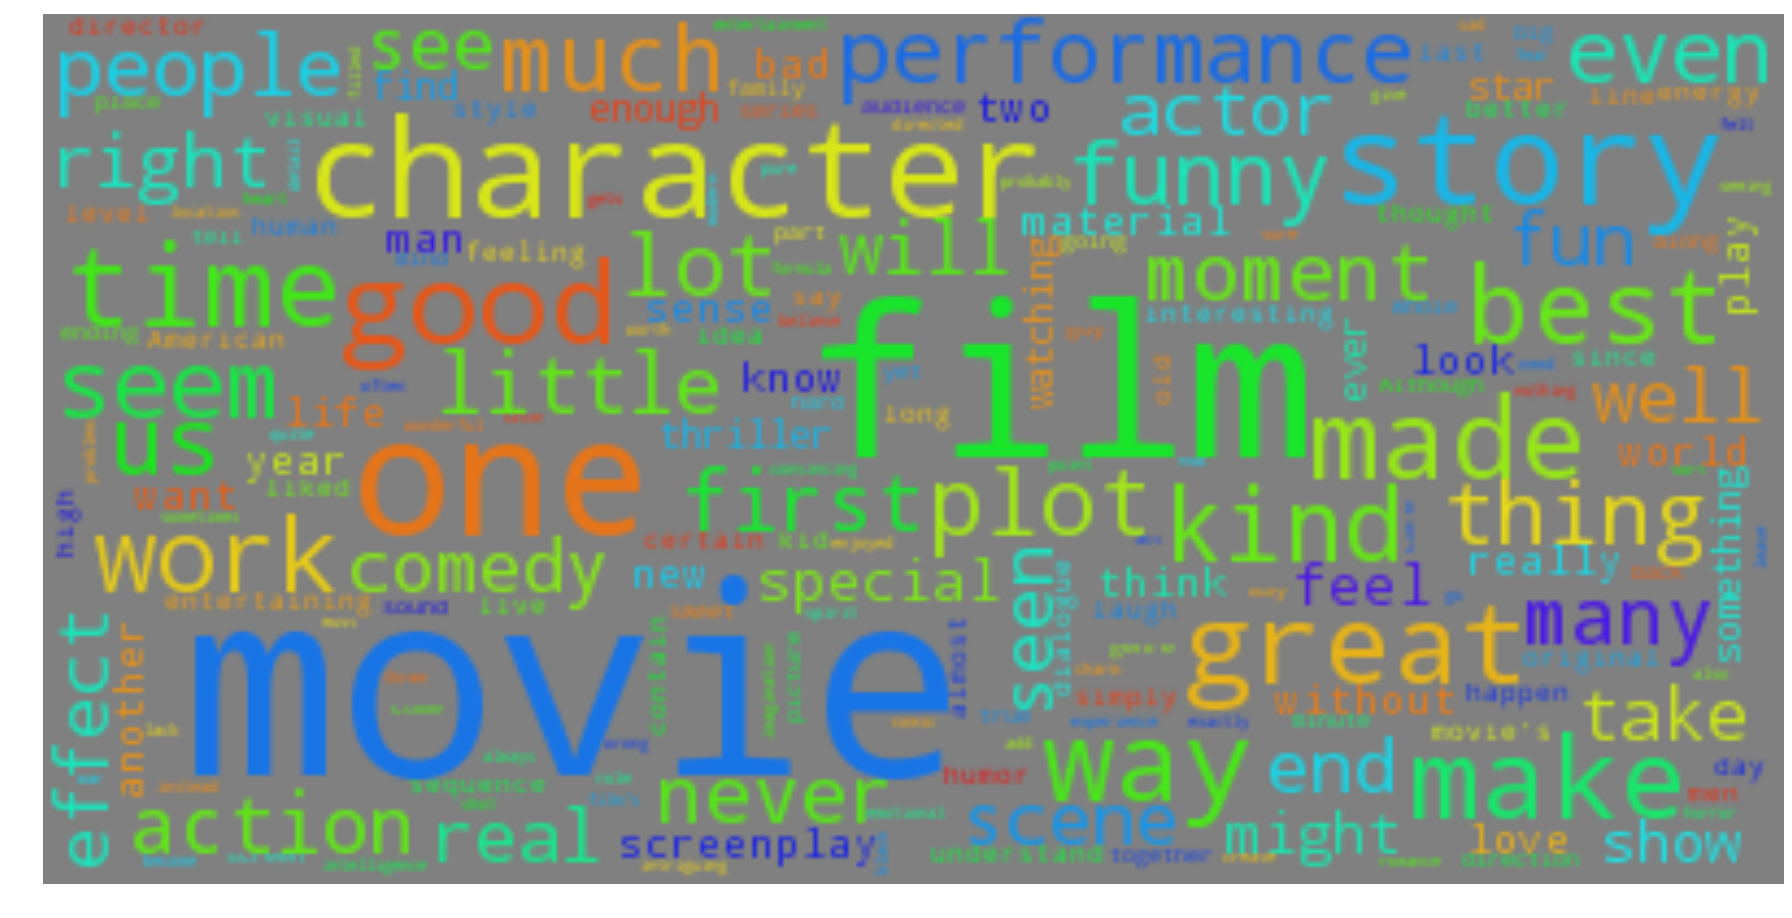

In [82]:
ebert_cloud = wordcloud.WordCloud(background_color='grey', max_font_size=60, relative_scaling=.5).generate(ebert_reviews)
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(ebert_cloud);

----

# Classify Fresh or Rotten

#### Split data

In [83]:
X = rt.clean_quote

y = (rt.fresh == 'fresh').values.astype(int)

print(X.shape)
print(y.shape)

(15534,)
(15534,)


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11650,)
(3884,)
(11650,)
(3884,)


### Start with simple BoW Multinomial NB

In [142]:
bow = CountVectorizer()

In [143]:
x1 = bow.fit_transform(X_train)

In [144]:
x1_test = bow.transform(X_test)

In [147]:
clf = MultinomialNB().fit(x1, y_train)
print ("MN Accuracy: %0.2f%%" % (100 * clf.score(x1_test, y_test)))

MN Accuracy: 76.78%


In [148]:
training_accuracy = clf.score(x1, y_train)
test_accuracy = clf.score(x1_test, y_test)

print ("Accuracy on training data: %0.2f" % (training_accuracy))
print ("Accuracy on test data:     %0.2f" % (test_accuracy))

Accuracy on training data: 0.90
Accuracy on test data:     0.77


>Model seems to be overfitting. Let's calculate cv scores to check.

In [150]:
cross_val_score(clf, x1, y_train).mean()

0.76120286700012185

ROC AUC: 0.84


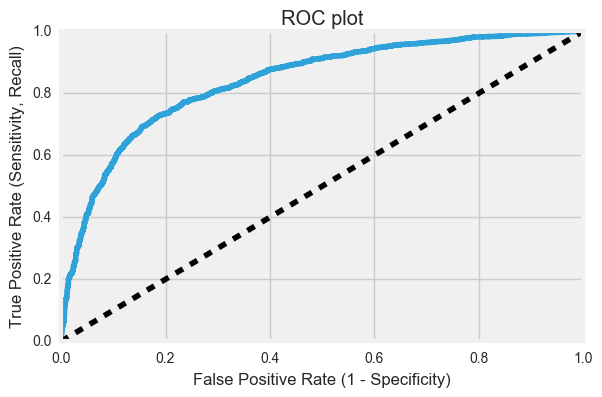

In [188]:
probabilities = clf.predict_proba(x1_test)[:, 1]

fpr,tpr,threshold = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
print ("ROC AUC: %0.2f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC plot")
plt.show()

> Looks a lot better. Let's interpret this first model.

In [156]:
words = np.array(bow.get_feature_names())

x = np.eye(x1_test.shape[1])
probs = clf.predict_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

In [157]:
print ("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print ("%20s" % w, "%0.2f" % (1 - (p)))

Good words	     P(fresh | word)
              honest 0.96
               intim 0.96
            outstand 0.96
           childhood 0.96
             delight 0.95
            expertli 0.95
              sublim 0.95
               etern 0.94
              deftli 0.94
           unforgett 0.94


In [158]:
print ("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print ("%20s" % w, "%0.2f" % (1 - (p)))

Bad words	     P(fresh | word)
           unsatisfi 0.07
            laughabl 0.07
             witless 0.07
            unfortun 0.07
                plod 0.06
             unfunni 0.06
             tiresom 0.06
           pointless 0.05
            uninspir 0.04
                lame 0.04


In [161]:
print(metrics.classification_report(clf.predict(x1_test), y_test))

             precision    recall  f1-score   support

          0       0.64      0.73      0.68      1309
          1       0.85      0.79      0.82      2575

avg / total       0.78      0.77      0.77      3884



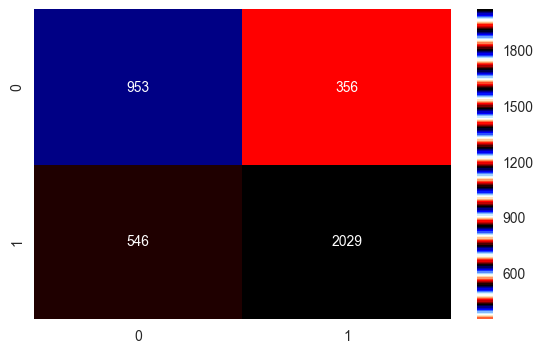

In [162]:
sns.heatmap(metrics.confusion_matrix(clf.predict(x1_test), y_test), annot=True,  fmt='', cmap= cm.flag);

## Let's see if we can improve our model.

#### Make a pipeline for Multinomial NB

In [100]:
nb_pipe = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])

In [101]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__min_df': (1e-5, 1e-4, 1e-3, 1e-2, 1e-1),
              'vect__stop_words': (None, 'english'),
              'tfidf__use_idf': (True, False),
              'clf__alpha': (0, .1, 1)}

In [102]:
nb_grid = GridSearchCV(nb_pipe, parameters, n_jobs=-1)

In [103]:
nb_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__alpha': (0, 0.1, 1, 5, 10, 50), 'tfidf__use_idf': (True, False), 'vect__min_df': (1e-05, 0.0001, 0.001, 0.01, 0.1), 'vect__ngram_range': [(1, 1), (1, 2)], 'vect__stop_words': (None, 'english')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [178]:
nb_grid.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1e-05,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        s...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [197]:
nb_grid.best_params_

{'clf__alpha': 0.1,
 'tfidf__use_idf': True,
 'vect__min_df': 1e-05,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [105]:
nb_grid.best_score_

0.75081545064377686

In [107]:
nb_grid.score(X_test, y_test)

0.75051493305870232

In [108]:
print(metrics.classification_report(nb_grid.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.51      0.77      0.61       988
          1       0.90      0.74      0.82      2896

avg / total       0.80      0.75      0.76      3884



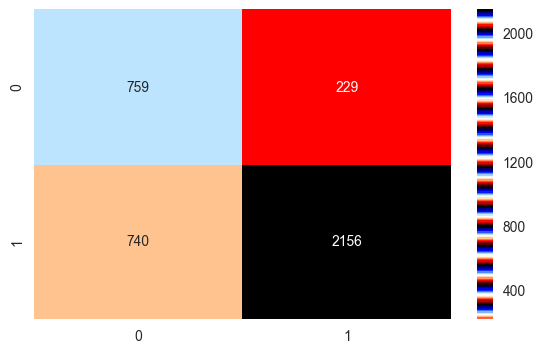

In [114]:
sns.heatmap(metrics.confusion_matrix(nb_grid.predict(X_test), y_test), annot=True,  fmt='', cmap= cm.flag);

ROC AUC: 0.84


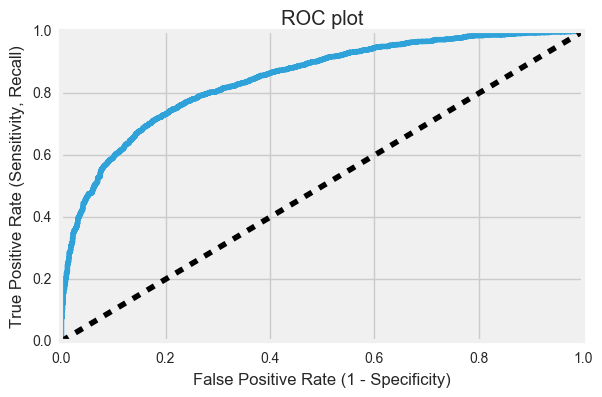

In [189]:
probabilities = nb_grid.predict_proba(X_test)[:, 1]

fpr,tpr,threshold = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
print ("ROC AUC: %0.2f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC plot")
plt.show()

## Let's tune & try other models

#### Logistic Regression

In [119]:
lr_pipe = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lr', LogisticRegression())
                     
])

In [123]:
parameters_lr = {'vect__ngram_range': [(1, 1), (1, 2)],
                 'vect__min_df': (1e-5, 1e-4, 1e-3, 1e-2, 1e-1),
                 'vect__stop_words': (None, 'english'),
                 'tfidf__use_idf': (True, False),
                 'lr__penalty': ['l1', 'l2'],
                 'lr__C': [1.0, 10.0, 100.0]
}

In [124]:
lr_grid = GridSearchCV(lr_pipe, parameters_lr, n_jobs=-1)

In [125]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'lr__C': [1.0, 10.0, 100.0], 'lr__penalty': ['l1', 'l2'], 'vect__ngram_range': [(1, 1), (1, 2)], 'vect__min_df': (1e-05, 0.0001, 0.001, 0.01, 0.1), 'vect__stop_words': (None, 'english'), 'tfidf__use_idf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [126]:
lr_grid.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1e-05,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        s...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [179]:
lr_grid.best_params_

{'lr__C': 100.0,
 'lr__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__min_df': 1e-05,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [127]:
lr_grid.best_score_

0.77270386266094415

In [128]:
lr_grid.score(X_test, y_test)

0.78063851699279097

In [129]:
print(metrics.classification_report(lr_grid.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.65      0.75      0.70      1315
          1       0.86      0.80      0.83      2569

avg / total       0.79      0.78      0.78      3884



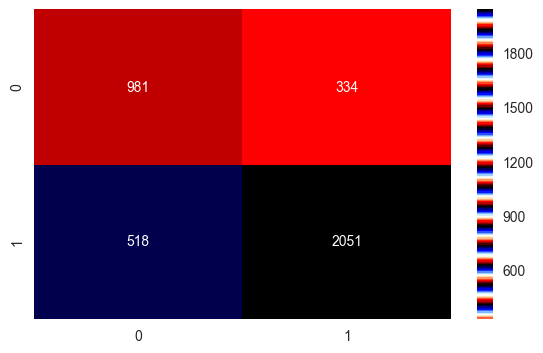

In [130]:
sns.heatmap(metrics.confusion_matrix(lr_grid.predict(X_test), y_test), annot=True,  fmt='', cmap= cm.flag);

ROC AUC: 0.86


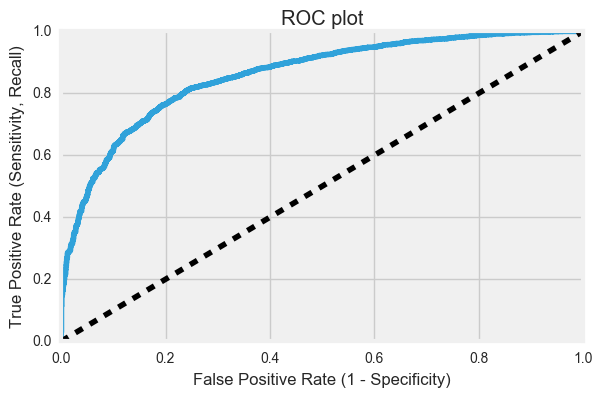

In [191]:
probabilities = lr_grid.predict_proba(X_test)[:, 1]

fpr,tpr,threshold = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
print ("ROC AUC: %0.2f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC plot")
plt.show()

#### Random Forest

In [163]:
rf_pipe = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('rf', RandomForestClassifier())
                     
])

In [167]:
parameters_rf = {'vect__ngram_range': [(1, 1), (1, 2)],
                 'vect__min_df': (1e-5, 1e-4),
                 'vect__stop_words': (None, 'english'),
                 'tfidf__use_idf': (True, False),
                 'rf__n_estimators': [10, 50, 100],
                 'rf__criterion': ['gini','entropy']
}

In [168]:
rf_grid = GridSearchCV(rf_pipe, parameters_rf, n_jobs=-1)

In [169]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'vect__min_df': (1e-05, 0.0001), 'vect__ngram_range': [(1, 1), (1, 2)], 'rf__criterion': ['gini', 'entropy'], 'rf__n_estimators': [10, 50, 100], 'vect__stop_words': (None, 'english'), 'tfidf__use_idf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [170]:
rf_grid.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1e-05,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
    ...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [198]:
rf_grid.best_params_

{'rf__criterion': 'entropy',
 'rf__n_estimators': 100,
 'tfidf__use_idf': False,
 'vect__min_df': 1e-05,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english'}

In [171]:
rf_grid.best_score_

0.71982832618025749

In [172]:
rf_grid.score(X_test, y_test)

0.74227600411946448

In [173]:
print(metrics.classification_report(rf_grid.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.55      0.72      0.62      1142
          1       0.86      0.75      0.80      2742

avg / total       0.77      0.74      0.75      3884



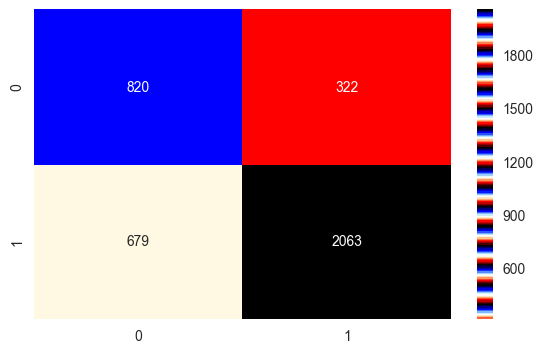

In [175]:
sns.heatmap(metrics.confusion_matrix(rf_grid.predict(X_test), y_test), annot=True,  fmt='', cmap= cm.flag);

ROC AUC: 0.81


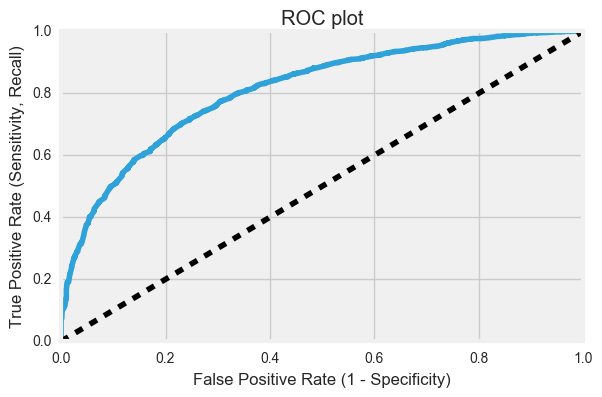

In [193]:
probabilities = rf_grid.predict_proba(X_test)[:, 1]

fpr,tpr,threshold = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
print ("ROC AUC: %0.2f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC plot")
plt.show()

In [185]:
print('My best model was: \n', lr_grid.best_params_)

My best model was: 
 {'lr__C': 100.0, 'lr__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__min_df': 1e-05, 'vect__stop_words': None}


# Future work
 - Word2Vec as a vectorizer.
 - Neural networks to classify.
 - Add in more features, treat the data as unlabeled & do some topic modeling.
 